# Explorations and tests with the heavier data-star

- dst28gm06n052

st28gm06n052_186.sav

st28gm06n052_190.sav

st28gm06n052_198.sav

In [1]:
# Check stellar props
from scipy.io.idl import readsav
import numpy as np
import analyze_co5bold_functions as c5d

teststar = readsav('../co5bold_data/dst28gm06n052/st28gm06n052_186.sav')
teststar = teststar['ful']

# Star's props
print(teststar['PAR'][0][0][2])

#Grid's props
# Size of grid
print(np.shape(teststar['EOS'][0][0][0]))

# Number of cells along each axis
print(teststar['Z'][0][0][4])

# Minimum cellsize:
AUcm = 1.49598e13 # cm
c5dgrid,cellcourners,cellsize = c5d.load_grid_properties(
    savpath='../co5bold_data/dst28gm06n052/st28gm06n052_186.sav'
)

print(f'Minimum cell: {cellsize/AUcm} AU')
print(f'Total size of grid: {(np.max(cellcourners)-np.min(cellcourners))/AUcm} AU')

# '3D dusty AGB star model: 1 M_Sun, 355 R_Sun, L=7000 L_Sun'
# > Teff = 2800K



/usr/lib/python3/dist-packages/scipy/io/idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


[b'Parameter file for RHD code:'
 b'3D dusty AGB star model: 1 M_Sun, 355 R_Sun, L=7000 L_Sun'
 b'Start model st28gm06n052_001.sta with 679^3 points'
 b'  based on st28gm06n050_300.end,'
 b'  extended inner and outer grid with rhd_manipulate.pro'
 b'Code version 2020-02-06:  MPI + OpenMP'
 b'Non-interacting forsterite+corundum dust, ar_dustrainabu: 3.0E-16'
 b'Non-grey 3-cluster opacity table:'
 b'  t2800gm050mm00_coma_opal_paola_oc1r_b3_n04.opta'
 b'"Big Box" buffer layer: N_radThinPoint=101+6, radThinHeatScheme=ConstantLum'
 b'Radiation pressure: radThinPressScheme=ConstantLum'
 b'From n034 on: c_radthintfactor=0.75->0.77']
(679, 679, 679)
[[-339  339]
 [-339  339]
 [-339  339]]
Minimum cell: 0.02582559459671921 AU
Total size of grid: 29.79639527908983 AU


In [17]:
# Create grid
import create_r3d_functions as c3d

# Smallest c5d cells are 0.026 AU
# Radius of star: 1.651AU (355 Rsun)
# Settings for the grid
AUcm = 1.49598e13 # cm
r3dedge = 29.796 * AUcm # Size of whole grid
basecell = 0.03*AUcm * 2**4 # Size of base cell (smallest cell is 0.03 AU)
nxyz = r3dedge/basecell
refinementlist_au = [9.5, 5.5, 3.5, 2.5]
refinementlist = [refs*AUcm for refs in refinementlist_au]

c3d.create_grid(
    gridedge=r3dedge/AUcm, 
    nxyz=nxyz, 
    refinementlist=refinementlist_au, 
    inrefine=0.13, 
    savegrid=True
)

# If I didn't have it already, create wavelength-grid here also!

Creating amr_grid with octree refinement.
Final length of total side of whole grid: 29.759999999999998 AU
Number of base cells along one side of the grid: 62
Distances to outer refinement limits from centrum: [9.5, 5.5, 3.5, 2.5] AU
Distances to inner refinement limits from centrum: [0.325, 0.65, 0.9750000000000001, 1.3] AU
Number refinements: 4
Size of base cell: 0.48 AU
Child cell size 1: 0.24 AU
Child cell size 2: 0.12 AU
Child cell size 3: 0.06 AU
Child cell size 4: 0.03 AU
Writing amr_grid.inp
Writing grid_distances.csv and grid_cellsizes.csv
(Not necessary for Radmc3d, but useful for pre/portprocessing of your model. They have the same order as dust_densities.inp)
Writing grid_info.txt
Create grid:
    amr_grid.inp
     grid_info.txt
    grid_distances.csv
    grid_cellsizes.csv
DONE



## Analyze input data

In [ ]:
# Plot densities as func of radius of all star-species
import analyze_r3d_functions as a3d

a3d.plot_alldensity_radius(
    path='../r3dresults/st28gm06n052/9species_186/'
)

In [ ]:
# Plot temperatures as func of radius of all star-species
import analyze_r3d_functions as a3d

a3d.plot_alltemperature_radius(
    path='../r3dresults/st28gm06n052/9species_186/'
)

In [ ]:
# Plot c5d's kappa in r3d-grid
import analyze_co5bold_functions as a5d

a5d.plot_opakapparadius(
    path='../r3dresults/st28gm06n052/9species_186/'
)


In [ ]:
# Plot all star-kappa as func of wavelength
import analyze_r3d_functions as a3d

a3d.plot_allkappa(
    path='../r3dresults/st28gm06n052/9species_186/'
)

## Analyze images and SED

In [ ]:
import analyze_r3d_functions as a3d
import matplotlib.pyplot as plt

path = '../r3dresults/st28gm06n052/9species_186/'

imagewaves = [1,10,1000]
images = [f'image_{imagewave}um.out' for imagewave in imagewaves]

testflux = a3d.plot_images(
    path=path,
    images=images,
    distance=1
)

maxflux,maxwave = a3d.plot_sed(path=f'{path}spectrum.out')

# Print luminosity in Lsols
# Wien's displacement law: freqmax = kb/h*T * 2.821439[..]
print(f"{a3d.compute_luminosity(path=f'{path}spectrum.out')/3.828e26} Lsol")
print(f'Max flux: {maxflux} Jy, at {maxwave} um.')
print(f'BB-temperature: {2.998e8/(5.879e10 * maxwave*1e-6)} K')

plt.plot(imagewaves,testflux,'r*')


# Test final create-stars-script

In [1]:
# With smoothing

import create_r3d_functions as c3d
import analyze_co5bold_functions as a5d
import analyze_r3d_functions as a3d
import os

# Some definitions
AUcm = 1.49598e13 # cm
modelname = 'st28gm06n052'
path = f'../r3dresults/{modelname}/'
phases = [186,190,198]


# Extract c5d grid size and star size in cm
c5dgrid,cellcourners,cellsize = a5d.load_grid_properties(
    savpath = f'../co5bold_data/d{modelname}/{modelname}_{phases[0]}.sav'
)
Mstar,Rstar,Lstar = a5d.load_star_information(
    savpath = f'../co5bold_data/d{modelname}/{modelname}_{phases[0]}.sav'
)


# Create spatial grid

# Settings for the grid
r3dedge = 2 * cellcourners.max() # Size of whole grid
basecell = cellsize*1.001 * 2**4 # Size of base cells (based on smallest cells and 4 refinements, make it slightly larger to be safe)
nxyz = r3dedge/basecell # Number of base cells per size

# Refinements based on stellar radius
refinementlist_au = [
    3.0*Rstar/AUcm,
    2.5*Rstar/AUcm,
    2.0*Rstar/AUcm,
    1.5*Rstar/AUcm
]

# Inner refinements up to 0.9 Rstar
inrefine_au = 0.9*Rstar/AUcm

# Create grid
c3d.create_grid(
    gridedge = r3dedge/AUcm, 
    nxyz = nxyz, 
    refinementlist = refinementlist_au, 
    inrefine = inrefine_au, 
    savegrid=True
)

# Move grid files to correct folder
os.system(
    f'mv ../amr_grid.inp {path}'
)
os.system(
    f'mv ../grid_info.txt {path}'
)
os.system(
    f'mv ../grid_distances.csv {path}'
)
os.system(
    f'mv ../grid_cellsizes.csv {path}'
)

# Create wavelength grid
wavelengths = c3d.create_wavelength(
    wavelengthstart = 0.1,
    wavelengthend = 1000.0,
    nwave = 100,
    logscale = 'y'
)

# Move wavelengthgrid to data-folder
os.system(
    f'mv ../wavelength_micron.inp {path}'
)

# List for stellar radii per phase
starradii = []

for phase in phases:
    # And copy wavelength-grid to each phase-folder
    os.system(
        f'cp {path}wavelength_micron.inp {path}{phase}/'
    )

    # Extract star's radius for each phase
    Mstar,Rstar,Lstar = a5d.load_star_information(
        savpath = f'../co5bold_data/d{modelname}/{modelname}_{phase}.sav',
        printoutput = 'n'
    )
    starradii.append(Rstar)


# Extract griddistances
griddistances = a3d.load_griddistances(
    gridpath= f'{path}grid_distances.csv',
    amrpath= f'{path}amr_grid.inp'
)[:,0]


# Create all r3d-data from c5d-data
a5d.create_stars(
    modelnames = [modelname],
    phases = phases
)


# Remove negative spikes in opacity and density to correct final luminosity
a5d.smooth_stellardata(
    path = path,
    phases = phases,
    starradii=starradii,
    griddistances=griddistances,
)


# Create radmc3d-run scripts
c3d.write_r3d_runscripts(
    path = path,
    phase_list = phases,
    sed_inclination_list = [0,90,180,270],
    image_wavelength_list = [1,10,100],
    image_inclination_list = [0,90,180,270],
    image_sizeau = r3dedge/AUcm,
    image_npix = 256,
)



print('All done')

/usr/lib/python3/dist-packages/scipy/io/idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


Stellar info: '3D dusty AGB star model: 1 M_Sun, 355 R_Sun, L=7000 L_Sun'
Creating amr_grid with octree refinement.
Final length of total side of whole grid: 29.780836060395945 AU
Number of base cells along one side of the grid: 72
Distances to outer refinement limits from centrum: [4.951319536357438, 4.126099613631198, 3.3008796909049587, 2.475659768178719] AU
Distances to inner refinement limits from centrum: [0.3713489652268079, 0.7426979304536158, 1.1140468956804235, 1.4853958609072315] AU
Number refinements: 4
Size of base cell: 0.4136227230610557 AU
Child cell size 1: 0.20681136153052784 AU
Child cell size 2: 0.10340568076526392 AU
Child cell size 3: 0.05170284038263196 AU
Child cell size 4: 0.02585142019131598 AU
Writing amr_grid.inp
Writing grid_distances.csv and grid_cellsizes.csv
(Not necessary for Radmc3d, but useful for pre/portprocessing of your model. They have the same order as dust_densities.inp)
Writing grid_info.txt
Create grid:
    amr_grid.inp
    grid_info.txt
    

In [1]:
# Manual change run scripts afterwards

import create_r3d_functions as c3d
import analyze_co5bold_functions as a5d

AUcm = 1.49598e13 # cm
modelname = 'st28gm06n052'
path = f'../r3dresults/{modelname}/'
phases = [186,190,198]


c5dgrid,cellcourners,cellsize = a5d.load_grid_properties(
    savpath = f'../co5bold_data/d{modelname}/{modelname}_{phases[0]}.sav'
)

# Settings for the grid
r3dedge = 2 * cellcourners.max() # Size of whole grid

# Create radmc3d-run scripts
c3d.write_r3d_runscripts(
    path = path,
    phase_list = phases,
    sed_inclination_list = [0,90,180,270],
    image_wavelength_list = [1,10,100],
    image_inclination_list = [0,90,180,270],
    image_sizeau = r3dedge/AUcm,
    image_npix = 256,
)


/usr/lib/python3/dist-packages/scipy/io/idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


Finished writing run-r3d-scripts:
    r3doutput_[PHASE].txt
    runcommand[PHASE].sh
    runcommand_main.sh



/tmp/ipykernel_26571/778947742.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


Lum (i = 0 deg): 5206.456654280256
Lum (i = 90 deg): 6487.268386139034
Lum (i = 180 deg): 7847.574604403732
Lum (i = 270 deg): 8308.462940410753
SED-Luminosity 186: 6962.440646308444 Lsol
BB-temperature 186: 2366.981344305215 K
Lum (i = 0 deg): 7179.914508747603
Lum (i = 90 deg): 6659.02673035107
Lum (i = 180 deg): 9186.486740931176
Lum (i = 270 deg): 8698.921673895798
SED-Luminosity 190: 7931.087413481413 Lsol
BB-temperature 190: 2366.981344305215 K
Lum (i = 0 deg): 8125.573297304738
Lum (i = 90 deg): 7001.353763832313
Lum (i = 180 deg): 8265.813187909982
Lum (i = 270 deg): 7905.813865192404
SED-Luminosity 198: 7824.638528559858 Lsol
BB-temperature 198: 2366.981344305215 K


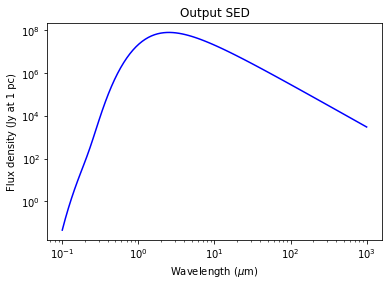

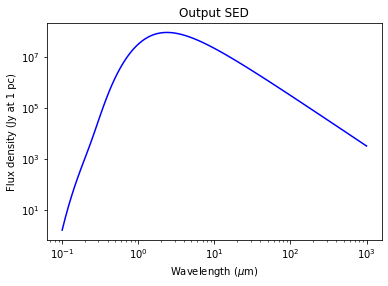

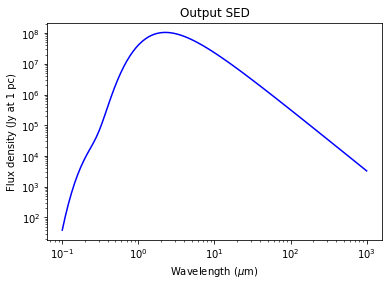

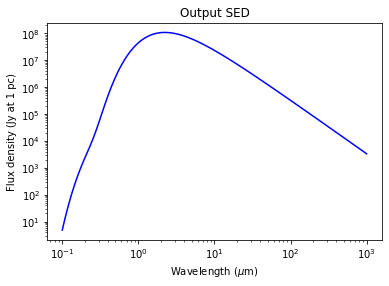

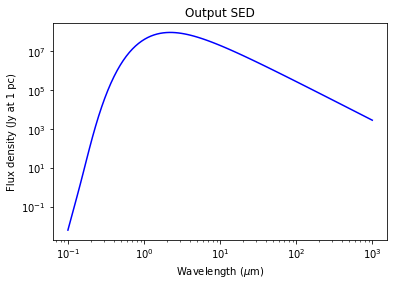

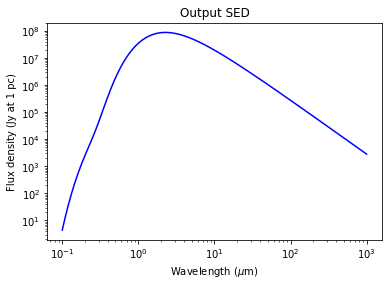

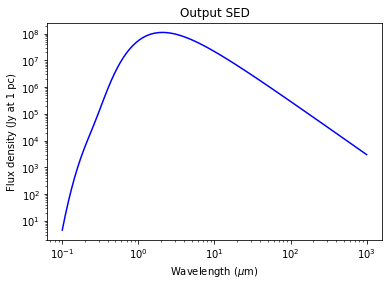

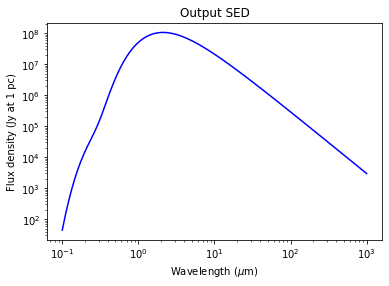

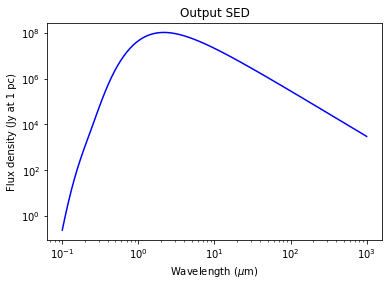

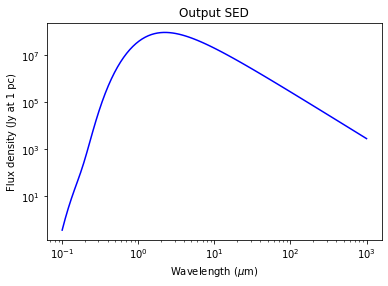

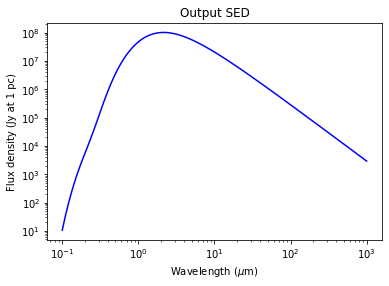

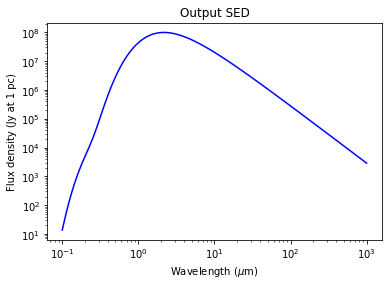

In [1]:
# Plot SEDs

import analyze_r3d_functions as a3d
import matplotlib.pyplot as plt

path = '../r3dresults/st28gm06n052/'
phases = [186,190,198]
sedincls = [0,90,180,270]

for phase in phases:

    lumtot = 0

    # Plot SEDs
    for sedincl in sedincls:
        fig,ax,maxflux,maxwave = a3d.plot_sed(
            path=f'{path}{phase}/spectrum_i{sedincl}.out'
        )
        fig.show();

        # Compute luminosity
        lum = a3d.compute_sed_luminosity(
            path=f'{path}{phase}/spectrum_i{sedincl}.out'
        )
        lumtot += lum
        print(f'Lum (i = {sedincl} deg): {lum/3.828e26}')

    lumtot /= len(sedincls)*3.828e26

    # Printouts
    print(f"SED-Luminosity {phase}: {lumtot} Lsol")
    print(f'BB-temperature {phase}: {2.998e8/(5.879e10 * maxwave*1e-6)} K')


['image_i0_1um.out']


/tmp/ipykernel_52101/3974580564.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


['image_i0_1um.out']
['image_i0_1um.out']


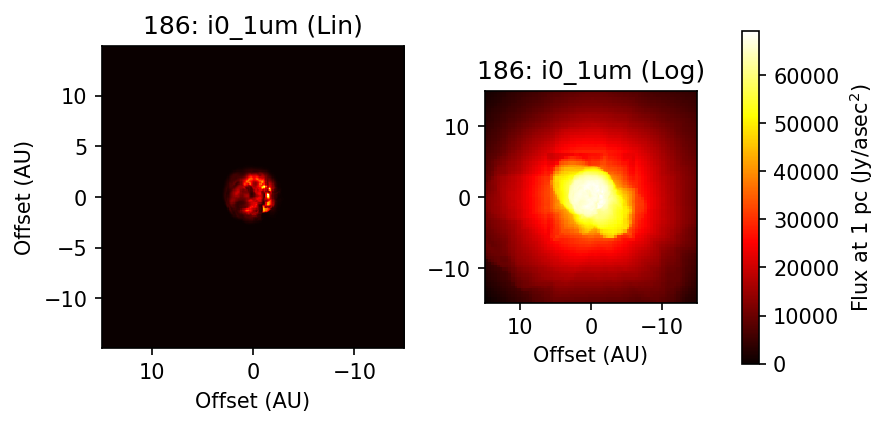

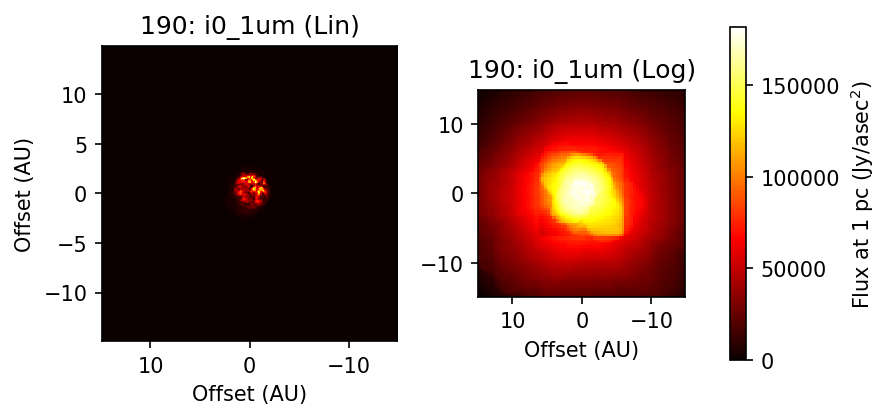

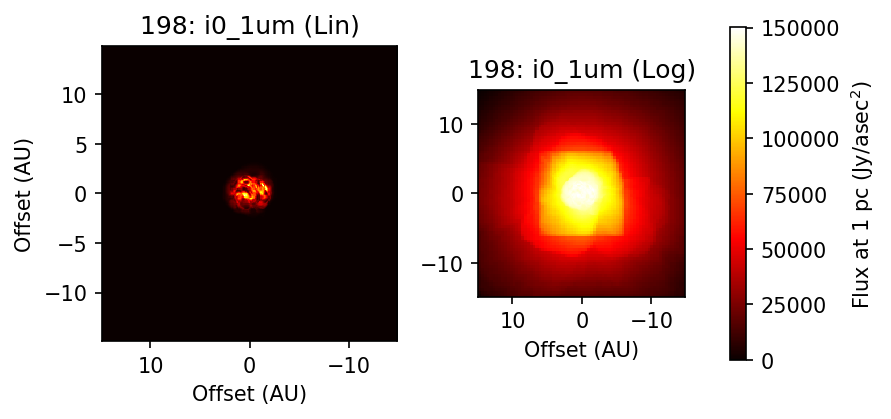

In [3]:
# Plot results

import analyze_r3d_functions as a3d
import matplotlib.pyplot as plt

path = '../r3dresults/st28gm06n052/'
phases = [186,190,198]
#imagewaves = [1,10,100]
#imageincls = [0,90,180,270]

#phases = [186]
imagewaves = [1]
imageincls = [0]

# List of image file names:
# Yes, I could use list compr, but this is easier to read
images = []
for imageincl in imageincls:
    for imagewave in imagewaves:
        images.append(f'image_i{imageincl}_{imagewave}um.out')


for phase in phases:
    # Plot images
    fig,ax,testflux = a3d.plot_images(
        path = f'{path}{phase}/',
        images = images,
        distance = 1
    )
    print(images)

    fig.tight_layout()
    fig.show()



# Find and save dust data

In [2]:
# Notebook for exploring the data insize the sav-file

import numpy as np
import matplotlib.pyplot as plt
from scipy.io.idl import readsav

AUcm = 1.49598e13 # cm

teststar = readsav('../co5bold_data/dst28gm06n052/st28gm06n052_186.sav')
teststar = teststar['ful']

# Dict-columns
print(teststar.dtype.names)
print('\n\n')

# Print some contents of your chosing
print(teststar['Z'][0][0][16])


('TYPE', 'HEAD', 'DATASET_ID', 'DATASET_ID__UNIT', 'DATASET_ID__NAME', 'MODELTIME', 'MODELTIME__UNIT', 'MODELTIME__NAME', 'MODELTIME_DB', 'MODELTIME_DB__UNIT', 'MODELTIME_DB__NAME', 'MODELITIME', 'MODELITIME__UNIT', 'MODELITIME__NAME', 'DTIME', 'DTIME__UNIT', 'DTIME__NAME', 'TIME_OUT_FULL_LAST', 'TIME_OUT_FULL_LAST__UNIT', 'TIME_OUT_FULL_LAST__NAME', 'TIME_OUT_MEAN_LAST', 'TIME_OUT_MEAN_LAST__UNIT', 'TIME_OUT_MEAN_LAST__NAME', 'Z', 'EOS', 'OPA', 'PAR')



b'time step number'


### Extract grain sizes tests

In [2]:
# Load gas and dust monomer densities
import analyze_co5bold_functions as a5d

gas_densities, dust_densities = a5d.load_dustgas_densities(
    savpath = '../co5bold_data/dst28gm06n052/st28gm06n052_186.sav',
    nspecies = 0
)

# write function that extracts these two densities only instead

# TODO
# write down the time it took for this!
# 56 min

/usr/lib/python3/dist-packages/scipy/io/idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


In [ ]:
import numpy as np

Amon = 2.3362e-22 # g
rhomon = 3.27 # g cm-3
nHnd = 3e-16
mH = 1.6726e-27 # g
epsilonHe = 0.1

grainsize_constants = (3/(4*np.pi) * Amon/rhomon * nHnd * mH * (1+epsilonHe))**(1/3)

print(grainsize_constants)

In [4]:
import numpy as np

A = np.array([0,1,2,3])
A[np.where(A > 0)[0][0]].min()


1

In [1]:
import analyze_co5bold_functions as a5d
a5d.extract_grainsizes()



Loading R3D grid
Loading C5D grid properties


/usr/lib/python3/dist-packages/scipy/io/idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


Computing grain sizes and saving them in R3D-grid (186)
Extracting gas and monomer densities from CO5BOLD-files (186)
Finished 25 per cent of the grid.
Finished 50 per cent of the grid.
Finished 75 per cent of the grid.
C5D grain sizes:
    grain_sizes_186.dat
DONE



In [1]:
import analyze_co5bold_functions as a5d
a5d.bin_grainsizes(
    grainsizepath='../grain_sizes_186.dat',
    phase='186',
    nbins=10,
    lin='y'
)


a5d.bin_grainsizes():
    grain_sizes_binned_186.dat
DONE



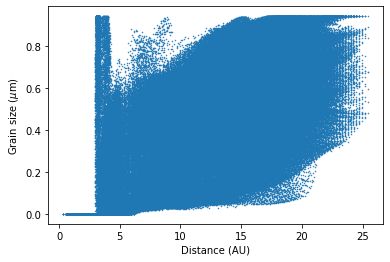

In [1]:
import analyze_r3d_functions as a3d
a3d.plot_grainsize_radius(
    grainsizepath='../grain_sizes_186.dat'
)


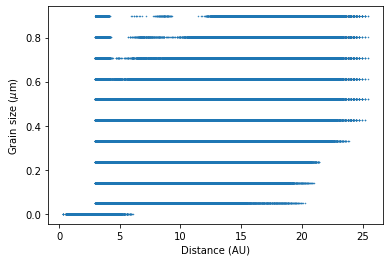

In [1]:
import analyze_r3d_functions as a3d
a3d.plot_grainsize_radius(
    grainsizepath='../grain_sizes_binned_186.dat'
)


In [ ]:
import analyze_co5bold_functions as a5d
a5d.plot_grainsize_distribution()

```
> nästa steg är att binna grain sizes:
    I creat-dust-grejen, läs grains-sizes-binned-filen
    Finns den inte: bry dig inte
    Finns den, spara en lista med grainsizes som skrivs med i dustopac-filen
    Loopa också över grainsizes och se till att dust_density etc skrivs
    på sådant vis att det är en specie per grain size bin
        Behöver bara den stora binned-filen, där ligger allt i rätt ordning
        Noll-celler är itne att bry sig om, där finns inget stoft

        och så får jag effektivisera min BHMie-funktion så att den kan ta in en lista av grain sizes och skapa alla nödvängida dustkappa_<specie>-<grainsize>um.inp

```

In [2]:
import numpy as np
import matplotlib.pyplot as plt

grainsizes_dat = np.loadtxt('../grain_sizes_186.dat')

grainsizes = []

for size in grainsizes_dat:
    if size > 0:
        grainsizes.append(size)


In [7]:
grainsizes_dat

grainsizes_dat[np.where(grainsizes_dat > 0)[0]].min()



6.272131978919615e-09

In [3]:
print(f"{np.min(grainsizes)} cm")
print(f"{np.max(grainsizes)} cm")
print(f"{np.mean(grainsizes)} cm")
print(f"{np.median(grainsizes)} cm")

6.272131978919615e-09 cm
9.438184519991895e-05 cm
4.879090569287237e-05 cm
5.3628270422397944e-05 cm


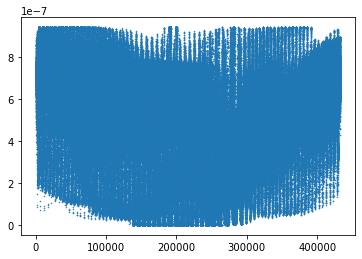

In [10]:
plt.plot(grainsizes,'.',markersize=1)

Text(0.5, 0, 'grainsize[meter]')

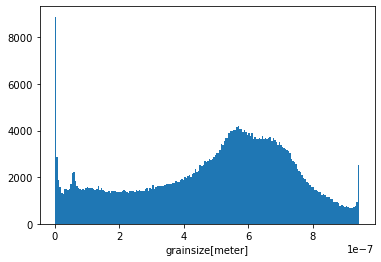

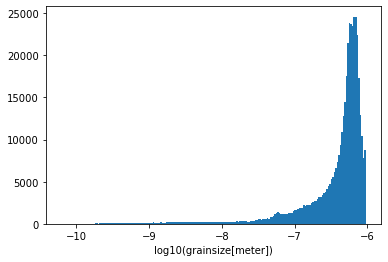

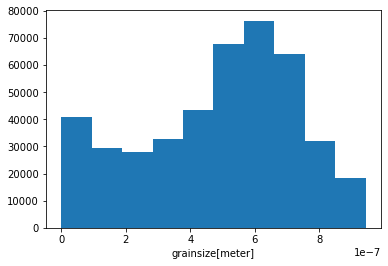

In [16]:
plt.figure(1)
plt.hist(grainsizes, bins=200);
plt.xlabel('grainsize[meter]')

plt.figure(2)
grainsizeslog = []
for size in grainsizes:
    grainsizeslog.append(np.log10(size))
plt.hist(grainsizeslog, bins=200);
plt.xlabel('log10(grainsize[meter])')

plt.figure(3)
plt.hist(grainsizes, bins=10);
plt.xlabel('grainsize[meter]')




In [4]:
import numpy as np

A = np.array([1,1,2,2,2,3,4,4])

print(np.unique(A))

[1 2 3 4]
